In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

In [2]:
#Load dataset
df = pd.read_csv("covid_deaths_linelist.csv")
print(df)

# Standardize column names
df.columns = df.columns.str.lower()

             date date_announced date_positive  date_dose1  date_dose2  \
0      2020-03-17     2020-03-17    2020-03-12         NaN         NaN   
1      2020-03-17     2020-03-17    2020-03-15         NaN         NaN   
2      2020-03-20     2020-03-20    2020-03-11         NaN         NaN   
3      2020-03-21     2020-03-21    2020-03-13         NaN         NaN   
4      2020-03-22     2020-03-22    2020-03-20         NaN         NaN   
...           ...            ...           ...         ...         ...   
37346  2024-01-30     2024-02-01    2024-01-30         NaN         NaN   
37347  2024-02-26     2024-02-29    2024-02-19  2021-06-21  2021-07-12   
37348  2024-03-27     2024-04-05    2024-03-24  2021-07-11  2021-08-01   
37349  2024-03-20     2024-04-24    2024-03-14  2021-05-18  2021-06-08   
37350  2024-05-18     2024-05-26    2024-05-18  2021-06-12  2021-07-03   

       date_dose3   brand1   brand2   brand3     state  age  male  bid  \
0             NaN      NaN      NaN  

In [3]:
# Clean and preprocess
df['bid'] = df['bid'].astype(int)
df['comorb'] = df['comorb'].fillna('Unknown')
df['brand1'] = df['brand1'].fillna('Unknown')

/tmp/ipython-input-4-1457964231.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='BID (1 = Yes)')


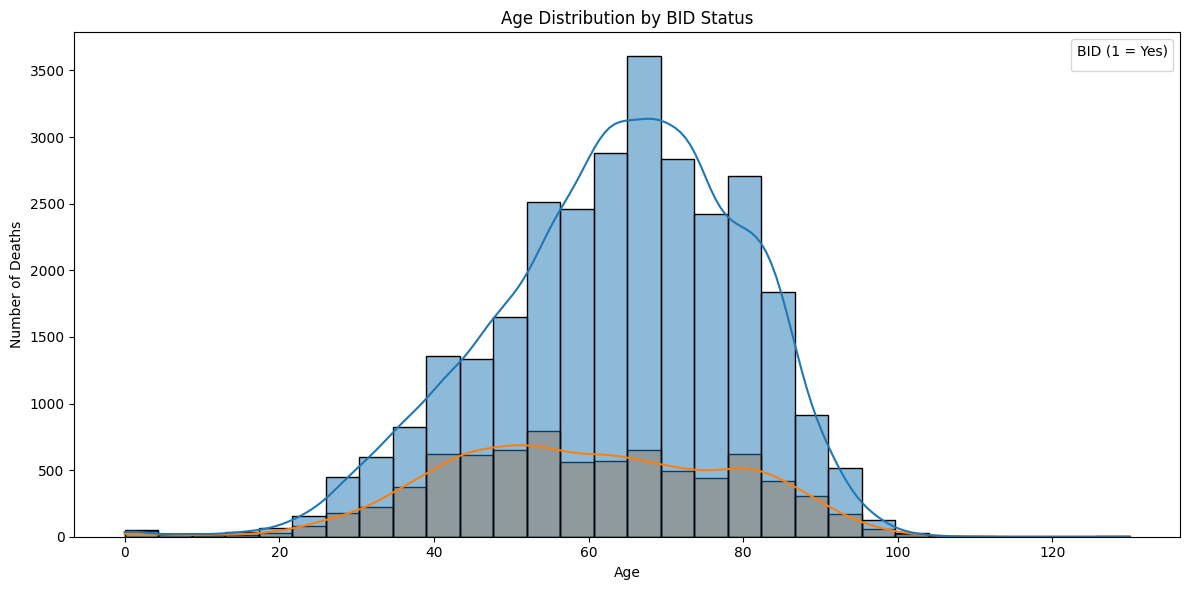

In [4]:
# 1. Age Distribution by BID
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='age', hue='bid', bins=30, kde=True)
plt.title('Age Distribution by BID Status')
plt.xlabel('Age')
plt.ylabel('Number of Deaths')
plt.legend(title='BID (1 = Yes)')
plt.tight_layout()
plt.show()

In [5]:
# 2. BID Proportion
bid_counts = df['bid'].value_counts(normalize=True)
print("BID Proportion:\n", bid_counts)

BID Proportion:
 bid
0    0.787342
1    0.212658
Name: proportion, dtype: float64


In [6]:
# 3. Comorbidity vs BID
comorb_bid = pd.crosstab(df['comorb'], df['bid'], normalize='index')
print("\nComorbidity vs BID:\n", comorb_bid)


Comorbidity vs BID:
 bid            0         1
comorb                    
0       0.635297  0.364703
1       0.828303  0.171697


In [7]:
# 4. Vaccine Brand Distribution
brand_counts = df['brand1'].value_counts()
print("\nTop Vaccine Brands:\n", brand_counts.head(10))


Top Vaccine Brands:
 brand1
Unknown             22475
Sinovac              8149
Pfizer               5572
AstraZeneca          1071
Cansino                68
Pending VMS sync        7
Sinopharm               7
Moderna                 2
Name: count, dtype: int64


In [8]:
# 5. State-wise BID Rate
state_bid_rate = df.groupby('state')['bid'].mean().sort_values(ascending=False)
print("\nTop 10 States by BID Rate:\n", state_bid_rate.head(10))


Top 10 States by BID Rate:
 state
Sabah                0.378420
W.P. Labuan          0.275000
W.P. Kuala Lumpur    0.255223
Kelantan             0.232867
Pulau Pinang         0.228463
Selangor             0.216067
Sarawak              0.198118
Kedah                0.191712
Perak                0.187671
Melaka               0.168704
Name: bid, dtype: float64


In [9]:
# Show initial missing value summary
print("Initial missing values per column:")
print(df.isnull().sum())

Initial missing values per column:
date                  0
date_announced        0
date_positive         0
date_dose1        22475
date_dose2        28075
date_dose3        35808
brand1                0
brand2            28075
brand3            35808
state                 0
age                   0
male                  0
bid                   0
malaysian             0
comorb                0
dtype: int64


In [10]:
# Replace placeholder strings that indicate missing data with np.nan
placeholders = ["Pending VMS sync", "Unknown", "Not Available", "N/A", "NA"]
for placeholder in placeholders:
    df.replace(placeholder, np.nan, inplace=True)

print("\nMissing values after replacing placeholders:")
print(df.isnull().sum())


Missing values after replacing placeholders:
date                  0
date_announced        0
date_positive         0
date_dose1        22475
date_dose2        28075
date_dose3        35808
brand1            22482
brand2            28080
brand3            35810
state                 0
age                   0
male                  0
bid                   0
malaysian             0
comorb                0
dtype: int64


In [11]:
# 1. Date fields: fill missing with mode (most frequent date)
date_fields = ['date', 'date_announced', 'date_positive', 'date_vaccine_1', 'date_vaccine_2', 'date_booster']
for col in date_fields:
    if col in df.columns:
        mode_value = df[col].mode(dropna=True)
        if not mode_value.empty:
            df[col] = df[col].fillna(mode_value[0])

In [12]:
# 2. Vaccine brand fields: fill missing with mode (most common vaccine)
vaccine_brand_fields = ['vaccine_brand_1', 'vaccine_brand_2', 'vaccine_brand_booster']
for col in vaccine_brand_fields:
    if col in df.columns:
        mode_value = df[col].mode(dropna=True)
        if not mode_value.empty:
            df[col].fillna(mode_value[0], inplace=True)

In [13]:
# 3. Age: fill missing with median age to avoid skew from outliers
if 'age' in df.columns:
    median_age = df['age'].median()
    df['age'] = df['age'].fillna(median_age)

In [14]:
# 4. Categorical fields like sex, state, citizenship, comorbidity: fill missing with mode
categorical_fields = ['sex', 'state', 'citizenship', 'comorbidity', 'Brought In Dead']
for col in categorical_fields:
    if col in df.columns:
        mode_value = df[col].mode(dropna=True)
        if not mode_value.empty:
            df[col] = df[col].fillna(mode_value[0])

# Final missing value check
print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
date                  0
date_announced        0
date_positive         0
date_dose1        22475
date_dose2        28075
date_dose3        35808
brand1            22482
brand2            28080
brand3            35810
state                 0
age                   0
male                  0
bid                   0
malaysian             0
comorb                0
dtype: int64


In [15]:
df['vaccinated_dose1'] = df['date_dose1'].notnull().astype(int)
df['vaccinated_dose2'] = df['date_dose2'].notnull().astype(int)
df['vaccinated_dose3'] = df['date_dose3'].notnull().astype(int)


In [16]:
# Select features
features = ['age', 'male', 'malaysian', 'comorb',
            'vaccinated_dose1', 'vaccinated_dose2', 'vaccinated_dose3', 'state']

# Target variable: Brought In Dead (bid) - binary classification
target = 'bid'

# Encode categorical variables (e.g., 'state', 'comorb')
for col in ['state', 'comorb']:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

# Ensure no missing values in selected features
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(df[features])
y = df[target].values

In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# --- Logistic Regression ---
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)[:,1]

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_prob_logreg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      5930
           1       0.38      0.48      0.42      1541

    accuracy                           0.73      7471
   macro avg       0.62      0.64      0.62      7471
weighted avg       0.76      0.73      0.74      7471

Logistic Regression ROC AUC: 0.6689588570090379


In [19]:
# --- Random Forest Classifier ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest ROC AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      5930
           1       0.40      0.24      0.30      1541

    accuracy                           0.77      7471
   macro avg       0.61      0.58      0.58      7471
weighted avg       0.74      0.77      0.75      7471

Random Forest ROC AUC: 0.6362740516932894


In [20]:
#Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# --- Step 4: Train Random Forest on resampled data ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# --- Step 5: Predict and evaluate ---
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("Random Forest + SMOTE Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

Random Forest + SMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      5930
           1       0.37      0.35      0.36      1541

    accuracy                           0.74      7471
   macro avg       0.60      0.60      0.60      7471
weighted avg       0.74      0.74      0.74      7471

ROC AUC Score: 0.6291703554228272


🔍 Logistic Regression Confusion Matrix:
[[4692 1238]
 [ 796  745]]
TP: 745, FP: 1238, FN: 796, TN: 4692

📊 Logistic Regression Performance:
Accuracy:  0.7277
Precision: 0.3757
Recall:    0.4835
F1-score:  0.4228
ROC AUC:   0.6690


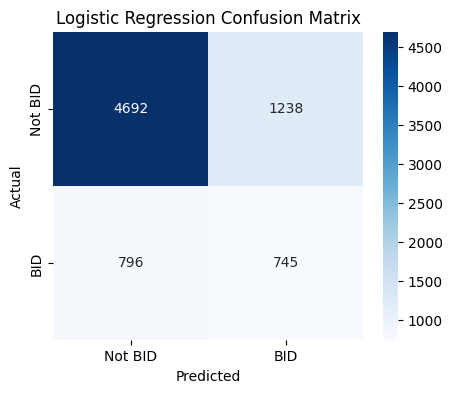

In [21]:
# --- Logistic Regression ---
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
tn_l, fp_l, fn_l, tp_l = cm_logreg.ravel()

print("🔍 Logistic Regression Confusion Matrix:")
print(cm_logreg)
print(f"TP: {tp_l}, FP: {fp_l}, FN: {fn_l}, TN: {tn_l}")

# Metrics
acc_l = (tp_l + tn_l) / (tp_l + tn_l + fp_l + fn_l)
prec_l = tp_l / (tp_l + fp_l) if (tp_l + fp_l) > 0 else 0
rec_l = tp_l / (tp_l + fn_l) if (tp_l + fn_l) > 0 else 0
f1_l = 2 * (prec_l * rec_l) / (prec_l + rec_l) if (prec_l + rec_l) > 0 else 0
roc_l = roc_auc_score(y_test, y_prob_logreg)

print("\n📊 Logistic Regression Performance:")
print(f"Accuracy:  {acc_l:.4f}")
print(f"Precision: {prec_l:.4f}")
print(f"Recall:    {rec_l:.4f}")
print(f"F1-score:  {f1_l:.4f}")
print(f"ROC AUC:   {roc_l:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=["Not BID", "BID"], yticklabels=["Not BID", "BID"])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


🔍 Random Forest + SMOTE Confusion Matrix:
[[5007  923]
 [ 999  542]]
TP: 542, FP: 923, FN: 999, TN: 5007

📊 Random Forest + SMOTE Performance:
Accuracy:  0.7427
Precision: 0.3700
Recall:    0.3517
F1-score:  0.3606
ROC AUC:   0.6292


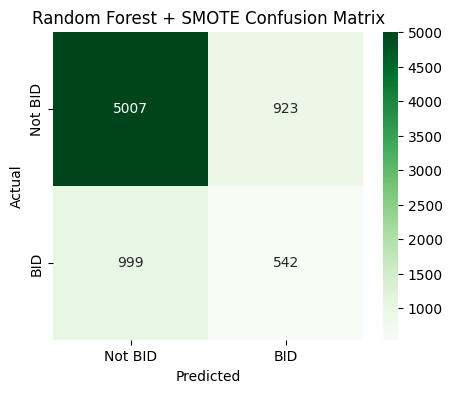

In [22]:
# --- Random Forest + SMOTE ---
cm_rf_smote = confusion_matrix(y_test, y_pred)
tn_r, fp_r, fn_r, tp_r = cm_rf_smote.ravel()

print("\n🔍 Random Forest + SMOTE Confusion Matrix:")
print(cm_rf_smote)
print(f"TP: {tp_r}, FP: {fp_r}, FN: {fn_r}, TN: {tn_r}")

# Metrics
acc_r = (tp_r + tn_r) / (tp_r + tn_r + fp_r + fn_r)
prec_r = tp_r / (tp_r + fp_r) if (tp_r + fp_r) > 0 else 0
rec_r = tp_r / (tp_r + fn_r) if (tp_r + fn_r) > 0 else 0
f1_r = 2 * (prec_r * rec_r) / (prec_r + rec_r) if (prec_r + rec_r) > 0 else 0
roc_r = roc_auc_score(y_test, y_prob)

print("\n📊 Random Forest + SMOTE Performance:")
print(f"Accuracy:  {acc_r:.4f}")
print(f"Precision: {prec_r:.4f}")
print(f"Recall:    {rec_r:.4f}")
print(f"F1-score:  {f1_r:.4f}")
print(f"ROC AUC:   {roc_r:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf_smote, annot=True, fmt='d', cmap='Greens', xticklabels=["Not BID", "BID"], yticklabels=["Not BID", "BID"])
plt.title("Random Forest + SMOTE Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
#Feature selection for Logistic Regression using L1
from sklearn.feature_selection import SelectFromModel
log_l1 = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=1000)
log_l1.fit(X_train, y_train)

selector_l1 = SelectFromModel(log_l1, prefit=True)
X_train_l1 = selector_l1.transform(X_train)
X_test_l1 = selector_l1.transform(X_test)

selected_features_l1 = [features[i] for i in range(len(features)) if selector_l1.get_support()[i]]
print("✅ Selected features using L1 (Logistic Regression):")
print(selected_features_l1)

✅ Selected features using L1 (Logistic Regression):
['age', 'male', 'malaysian', 'comorb', 'vaccinated_dose1', 'vaccinated_dose2', 'vaccinated_dose3', 'state']


In [25]:
#Feature selection for Random Forest using feature importances
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [26]:
# Get feature importance
importances = rf.feature_importances_
feature_ranking = pd.Series(importances, index=features).sort_values(ascending=False)

print("\n📊 Feature importance (Random Forest):")
print(feature_ranking)

# Top N features
top_n = 5
top_features_rf = feature_ranking.head(top_n).index.tolist()
print(f"\n✅ Top {top_n} features for Random Forest:")
print(top_features_rf)


📊 Feature importance (Random Forest):
age                 0.397883
state               0.201524
comorb              0.105326
malaysian           0.101650
male                0.087731
vaccinated_dose1    0.051358
vaccinated_dose2    0.034371
vaccinated_dose3    0.020157
dtype: float64

✅ Top 5 features for Random Forest:
['age', 'state', 'comorb', 'malaysian', 'male']


In [27]:
# --- Step 1: Keep only top 5 features ---
top_features_rf = ['age', 'state', 'comorb', 'malaysian', 'male']

# Extract top 5 features from original train/test sets
X_train_top = pd.DataFrame(X_train, columns=features)[top_features_rf].values
X_test_top = pd.DataFrame(X_test, columns=features)[top_features_rf].values

# --- Step 2: Apply SMOTE to balance the training set ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_top, y_train)

# --- Step 3: Train Random Forest on selected features ---
rf_top = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top.fit(X_train_resampled, y_train_resampled)

# --- Step 4: Predict and evaluate performance ---
y_pred_top = rf_top.predict(X_test_top)
y_prob_top = rf_top.predict_proba(X_test_top)[:, 1]

# Classification report
print("📊 Random Forest (Top 5 Features + SMOTE) Classification Report:")
print(classification_report(y_test, y_pred_top))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_top)
print("\n🔎 Confusion Matrix:\n", cm)

# ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob_top)
print(f"\n🎯 ROC AUC Score: {roc_auc:.4f}")

📊 Random Forest (Top 5 Features + SMOTE) Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      5930
           1       0.35      0.37      0.36      1541

    accuracy                           0.73      7471
   macro avg       0.59      0.60      0.60      7471
weighted avg       0.73      0.73      0.73      7471


🔎 Confusion Matrix:
 [[4879 1051]
 [ 969  572]]

🎯 ROC AUC Score: 0.6163


In [28]:
threshold = 0.3
y_pred_custom = (y_prob >= threshold).astype(int)

# --- Step 5: Evaluasi model dengan threshold baru ---
print("Classification Report dengan threshold 0.3:")
print(classification_report(y_test, y_pred_custom))

print("Confusion Matrix dengan threshold 0.3:")
cm = confusion_matrix(y_test, y_pred_custom)
print(cm)

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

Classification Report dengan threshold 0.3:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76      5930
           1       0.30      0.52      0.38      1541

    accuracy                           0.65      7471
   macro avg       0.57      0.60      0.57      7471
weighted avg       0.73      0.65      0.68      7471

Confusion Matrix dengan threshold 0.3:
[[4065 1865]
 [ 746  795]]
ROC AUC Score: 0.6292


In [29]:
import pickle

# Save your trained model (replace rf with your trained model variable)
with open('rf_smote_model.pkl', 'wb') as file:
    pickle.dump(rf, file)


In [30]:
from google.colab import files
files.download('rf_smote_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>